# Hourly Energy Consumption.
![energy](energy.jpg)

# Giới thiệu project

<h3>Chủ đề: <strong>Hourly Energy Consumption.</strong></h3>

<h3>Phân loại bài toán: <strong>Time Series Forecasting</strong></h3>

<h3>Mục tiêu: </h3>
<p>

- Phân tích xu hướng tiêu thụ điện theo thời gian của một khu vực.

- Xây dựng mô hình dự báo tiêu thụ điện năng.

- Trình bày kết quả bằng đồ thị và báo cáo chi tiết.
</p>

<h3>Mô hình sử dụng: <strong>XGBoost (xgb)</strong></h3>

<h3>Giới thiệu về mô hình:</h3>
<p>XGBoost (Extreme Gradient Boosting) là một thuật toán học máy mạnh mẽ và phổ biến, nổi bật nhờ khả năng xử lý tốt các bài toán dự đoán với dữ liệu có tính phi tuyến và tương tác phức tạp giữa các đặc trưng. Mặc dù ban đầu XGBoost không được thiết kế chuyên biệt cho bài toán chuỗi thời gian, nhưng với việc xây dựng các đặc trưng hợp lý (feature engineering), nó trở thành một trong những lựa chọn hiệu quả trong dự báo chuỗi thời gian thực tế.</p>
<p>
Trong Time Series Forecasting, XGBoost có thể khai thác thông tin từ các đặc trưng như:

- <strong>Độ trễ (lag features)</strong>: đại diện cho các giá trị lịch sử gần.

- <strong>Khác biệt (differences)</strong>: biểu diễn xu hướng thay đổi theo thời gian.

- <strong>Đặc trưng thời gian (time-based features)</strong>: như giờ, ngày, tuần, tháng, năm hoặc các đặc trưng Fourier cho chu kỳ.

- <strong>Rolling statistics</strong>: ví dụ như rolling mean hoặc rolling std để mô tả hành vi cục bộ.</p>

---

## Import thư viện



- Xử lý và phân tích dữ liệu: `pandas`, `numpy`
- Vẽ biểu đồ: `matplotlib`, `seaborn`
- Dự báo và học máy: `xgboost`, `RandomForestRegressor`
- Đánh giá mô hình: `mean_absolute_error`, `mean_squared_error`, `r2_score`
- Phân tích chuỗi thời gian: `plot_acf`, `adfuller`
- Tiền xử lý và quy trình huấn luyện mô hình: `Pipeline`, `FunctionTransformer`


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

---
# 1. Thu thập dữ liệu

---
# 2. Khám phá dữ liệu

In [3]:
PJME_df_origin = pd.read_csv('PJME_hourly.csv', encoding='utf-8-sig')

PJME_df = PJME_df_origin.copy()
PJME_df.head(5)

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


### Kích thước và kiểu dữ liệu của các cột

In [4]:
# Các cột hiện có kiểu dữ liệu gì?
PJME_df.dtypes

Datetime     object
PJME_MW     float64
dtype: object

In [5]:
PJME_df.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


Chuyển kiểu dữ liệu của cột `Datetime` từ dạng `object` (chuỗi) sang kiểu `datetime` để hỗ trợ xử lý dữ liệu thời gian như phân tích theo ngày, giờ, hoặc tạo chỉ mục thời gian.


In [6]:
# Xử lý cột có thể bị lỗi tên
PJME_df.columns = PJME_df.columns.str.strip()  # Xóa khoảng trắng

# In thử tên cột để chắc chắn
print(PJME_df.columns.tolist())

PJME_df['Datetime'] = pd.to_datetime(PJME_df['Datetime'])
PJME_df = PJME_df.set_index('Datetime')

['Datetime', 'PJME_MW']


### Kiểm tra dữ liệu bị trùng

In [7]:
print("Check of Duplicates (Datetime):")
duplicate = PJME_df[PJME_df.index.duplicated(keep=False)]
duplicate

Check of Duplicates (Datetime):


,PJME_MW
Datetime,
2014-11-02 02:00:00,22935.0
2014-11-02 02:00:00,23755.0
2015-11-01 02:00:00,21567.0
2015-11-01 02:00:00,21171.0
2016-11-06 02:00:00,20795.0
2016-11-06 02:00:00,21692.0
2017-11-05 02:00:00,21236.0
2017-11-05 02:00:00,20666.0


### Kiểm tra dữ liệu bị thiếu

In [8]:
start = PJME_df.index.min()
end = PJME_df.index.max()

full_range = pd.date_range(start=start, end=end, freq='h') # Tạo dải thời gian đầy đủ theo từng giờ

missing_dates = full_range.difference(PJME_df.index)

print(f"Số lượng thời điểm bị thiếu: {len(missing_dates)}")
missing_dates

Số lượng thời điểm bị thiếu: 30


DatetimeIndex(['2002-04-07 03:00:00', '2002-10-27 02:00:00',
               '2003-04-06 03:00:00', '2003-10-26 02:00:00',
               '2004-04-04 03:00:00', '2004-10-31 02:00:00',
               '2005-04-03 03:00:00', '2005-10-30 02:00:00',
               '2006-04-02 03:00:00', '2006-10-29 02:00:00',
               '2007-03-11 03:00:00', '2007-11-04 02:00:00',
               '2008-03-09 03:00:00', '2008-11-02 02:00:00',
               '2009-03-08 03:00:00', '2009-11-01 02:00:00',
               '2010-03-14 03:00:00', '2010-11-07 02:00:00',
               '2010-12-10 00:00:00', '2011-03-13 03:00:00',
               '2011-11-06 02:00:00', '2012-03-11 03:00:00',
               '2012-11-04 02:00:00', '2013-03-10 03:00:00',
               '2013-11-03 02:00:00', '2014-03-09 03:00:00',
               '2015-03-08 03:00:00', '2016-03-13 03:00:00',
               '2017-03-12 03:00:00', '2018-03-11 03:00:00'],
              dtype='datetime64[ns]', freq=None)

##### Fact: Các thời điểm thiếu do sự thay đổi giữa giờ chuẩn và giờ mùa hè (DST)

Các thời điểm thiếu hoặc trùng lặp như `2002-04-07 03:00:00`, `2003-04-06 03:00:00`, v.v. đều rơi vào mùa xuân hoặc mùa thu, khi có sự thay đổi giữa giờ chuẩn và giờ mùa hè. 

- **Giờ mùa hè (DST)**: Trong một số quốc gia, vào mùa xuân và mùa thu, thời gian sẽ thay đổi — thường là giảm hoặc tăng một giờ. Ví dụ: 
  - Từ 3:00 AM có thể chuyển thành 2:00 AM (khi đổi từ giờ mùa hè về giờ chuẩn) hoặc 4:00 AM (khi đổi từ giờ chuẩn sang giờ mùa hè).
  
- **Nguyên nhân các thời điểm thiếu/lặp**: Các thời điểm này có dữ liệu được thu thập bất thường vì khi đồng hồ được chỉnh lại vào mùa hè, một số thời điểm sẽ bị "bỏ qua" hoàn toàn trong chuỗi thời gian (nếu tăng một giờ), hoặc lặp lại (nếu lùi 1 giờ). 

In [9]:
# Lấy trung bình các dòng bị lặp
def mean_duplicate_rows(df) :
    duplicate = df[df.index.duplicated(keep=False)]
    dup_mean = duplicate.groupby(level=0).mean(numeric_only=True)

    df.drop(index=duplicate.index, inplace=True)

    df_meaned = pd.concat([df, dup_mean])

    df_meaned = df_meaned.resample('h').mean()  # Lấy trung bình của các giờ được thu thập dữ liệu nhiều lần (vd như lẻ 15ph, 30ph)
    return df_meaned

# Nội suy các thời điểm bị thiếu
def interpolate_missing_rows(df) :
    start = df.index.min()
    end = df.index.max()
    full_range = pd.date_range(start=start, end=end, freq='h') # Tạo dải thời gian đầy đủ theo từng giờ

    missing_dates = full_range.difference(df.index)

    df_missing = pd.DataFrame(index=missing_dates, columns=df.columns)
    df_full = pd.concat([df, df_missing]).sort_index()        # Thêm các Datetime đang missing vào
    
    df_full = df_full.infer_objects()
    df_full.interpolate(method='time', inplace=True)   # Nội suy cột Năng lượng ..._MW

    return df_full

# 3. Tạo các đặc trưng thời gian (time-based features)

Trích xuất thêm các đặc trưng từ cột `Datetime` như năm, quý, tháng, ngày, giờ, thứ trong tuần, ngày trong năm, cuối tuần và mùa trong năm. Những đặc trưng này có thể giúp mô hình học được các xu hướng theo thời gian và cải thiện hiệu suất dự đoán.


In [10]:
def create_features_Datetime(df):

  df['Year'] = df.index.year
  df['Quarter'] = df.index.quarter
  df['Month'] = df.index.month
  df['Day'] = df.index.day

  df['Hour'] = df.index.hour
  df['Sin_h'] = np.sin(2 * np.pi * df['Hour'] / 24)
  df['Cos_h'] = np.cos(2 * np.pi * df['Hour'] / 24)

  df['Day_of_Year'] = df.index.dayofyear
  df['Sin_doy'] = np.sin(2 * np.pi * df['Day_of_Year'] / 365)
  df['Cos_doy'] = np.cos(2 * np.pi * df['Day_of_Year'] / 365)

  df['Weekday'] = df.index.weekday
  df['Is_Weekend'] = df['Weekday'].isin([5, 6]).astype(np.int8)

  df['Season'] = df['Month'].apply(lambda x: 
                                             1 if (x >= 3 and x <= 5) else  # Xuân
                                             2 if (x >= 6 and x <= 8) else  # Hạ
                                             3 if (x >= 9 and x <= 11) else  # Thu
                                             4) # Đông

  return df

In [11]:
create_features_Datetime(PJME_df).head()

,PJME_MW,Year,Quarter,Month,Day,Hour,Sin_h,Cos_h,Day_of_Year,Sin_doy,Cos_doy,Weekday,Is_Weekend,Season
Datetime,,,,,,,,,,,,,,
2002-12-31 01:00:00,26498.0,2002,4,12,31,1,0.258819,0.965926,365,6.432491e-16,1.0,1,0,4
2002-12-31 02:00:00,25147.0,2002,4,12,31,2,0.500000,0.866025,365,6.432491e-16,1.0,1,0,4
2002-12-31 03:00:00,24574.0,2002,4,12,31,3,0.707107,0.707107,365,6.432491e-16,1.0,1,0,4
2002-12-31 04:00:00,24393.0,2002,4,12,31,4,0.866025,0.500000,365,6.432491e-16,1.0,1,0,4
2002-12-31 05:00:00,24860.0,2002,4,12,31,5,0.965926,0.258819,365,6.432491e-16,1.0,1,0,4


---
# 4. Tạo các đặc trưng ghi nhớ 
<ul>
    <li>lag                : Độ trễ</li> 
    <li>differences (diff) : Độ biến thiên</li> 
    <li>rolling statistic  : Thống kê trượt</li>
</ul>

In [12]:
def feature_engineering(df):
    df = df.copy()

    # Rolling statistics (shift bằng window để căn chỉnh ngày/tuần)
    for window in [24, 24*7]:
        df[f'rolling_mean_{window}h'] = df.iloc[:, 0].shift(1).rolling(window=window).mean()      # window=24 thì rolling[-24, -1]
        df[f'rolling_std_{window}h'] = df.iloc[:, 0].shift(1).rolling(window=window).std()
        df[f'rolling_min_{window}h'] = df.iloc[:, 0].shift(1).rolling(window=window).min()
        df[f'rolling_max_{window}h'] = df.iloc[:, 0].shift(1).rolling(window=window).max()

        df[f'rolling_mean_{window}h_lag_{window}h'] = df.iloc[:, 0].shift(window).rolling(window=window).mean()      # window=24 thì rolling[-48, -24]
        df[f'rolling_std_{window}h_lag_{window}h'] = df.iloc[:, 0].shift(window).rolling(window=window).std()
        df[f'rolling_min_{window}h_lag_{window}h'] = df.iloc[:, 0].shift(window).rolling(window=window).min()
        df[f'rolling_max_{window}h_lag_{window}h'] = df.iloc[:, 0].shift(window).rolling(window=window).max()


    # Tính lag_diff. 
    # Vd diff_1d_lag_2d là độ biến thiên của hôm kia so với hôm kìa 
    # base_1h là giá trị của giờ trước đó
    for diff, lag in [(1, 24), (24, 6), (24*7, 5), (24*365, 4)]:
        df[f'lag_{diff}h'] = df.iloc[:, 0].shift(diff)         # là lag_24h với delay 24h nữa, a.k.a lag_48h nhưng cũng không hẳn
        diff_value = df.iloc[:,0].diff(diff) / df[f'lag_{diff}h']  # lẩy phần trăm, chuyển là diff theo %

        df[f'diff_{diff}h_lag_{diff}h'] = diff_value.shift(diff)    # tạo lag để tránh leakage
        for i in range(2, lag+1) :
            df[f'diff_{diff}h_lag_{i*diff}h'] = df[f'diff_{diff}h_lag_{(i-1)*diff}h'].shift(diff)
            

    # Drop rows with any NaN values
    # Lưu ý đoạn trên, nếu diff * lag quá lớn thì drop gần hết bảng
    df.dropna(inplace=True)

    return df

---
# **. Tổng hợp pipe tiền xử lí

In [13]:
full_preprocessing_pipeline = Pipeline(steps=[
    ('Lấy trung bình các dòng bị lặp', FunctionTransformer(mean_duplicate_rows)),
    ('Nội suy các dòng thiếu', FunctionTransformer(interpolate_missing_rows)),
    ('Tạo features từ index Datetime', FunctionTransformer(create_features_Datetime)),
    ('Tạo features từ cột MW (gốc)', FunctionTransformer(feature_engineering))
])

# 1. Nửa đầu: xử lý missing_values, duplicate_time
fulfill_pipeline = Pipeline(steps=[
    ('Lấy trung bình các dòng bị lặp', FunctionTransformer(mean_duplicate_rows)),
    ('Nội suy các dòng thiếu', FunctionTransformer(interpolate_missing_rows))
])

# 2. Nửa sau: tạo features
feature_engineering_pipeline = Pipeline(steps=[
    ('Tạo features từ index Datetime', FunctionTransformer(create_features_Datetime)),
    ('Tạo features từ cột MW (gốc)', FunctionTransformer(feature_engineering))
])

# 5. Lọc lại các đặc trưng

In [14]:
def select_features_by_correlation(corr_matrix, target_col='PJME_MW', threshold=0.8):
    # 1. Lấy tất cả các feature (không lọc theo tương quan với target)
    all_features = [col for col in corr_matrix.columns if col != target_col]
    
    # 2. Lấy tương quan của các feature với target để so sánh
    target_corr = corr_matrix[target_col].drop(target_col)
    
    # 3. Duyệt các cặp feature và loại bỏ nếu tương quan lớn hơn threshold (đa cộng tuyến)
    to_remove = set()
    # for i in range(len(all_features)):
    #     for j in range(i + 1, len(all_features)):
    #         f1, f2 = all_features[i], all_features[j]
    #         # Nếu abs(tương quan của f1, f2) > threshold
    #         if abs(corr_matrix.loc[f1, f2]) > threshold:
    #             # Nếu abs(tương quan của f1 với target) lớn hơn thì bỏ f2
    #             if abs(target_corr[f1]) > abs(target_corr[f2]):
    #                 to_remove.add(f2)
    #             else:
    #                 to_remove.add(f1)
    
    # 4. Loại bỏ các feature trong to_remove
    final_features = [f for f in all_features if f not in to_remove]
    
    return final_features

---
# 6. Xây dựng mô hình

## 6.1. Phương pháp dự đoán:
<ol>
    <li>Phân tách dữ liệu:<br> Ta tiến hành chỉnh sửa hoàn thiện trước các khoảng trống của dữ liệu, sau đó phân tách theo dòng thời gian, với 80% dùng cho huấn luyện mô hình, và 20% cho đối chiếu. Trong trường hợp với bộ dữ liệu ít hơn, ta cũng xét tới việc tách 1 năm cuối cùng để đối chiếu, thay vì chia tỉ lệ</li>
    <li>Huấn luyện mô hình XGBoost:<br> Dựa trên tập huẩn luyện (training_data), ta tạo các đặc trưng có ý nghĩa như đã thực hiện lọc ở phần trên, và đưa các mẫu để huấn luyện mô hình. Việc lựa chọn các tham số để cải thiến tiến trình, kết quả và mức ăn khớp của mô hình trên các 2 tập dữ liệu sẽ được đề cập sau.</li>
    <li>Thực hiện dự đoán:<br> Ta bắt đầu với training_data như một dữ liệu bối cảnh (context). Thực hiện tạo sinh các đặc trưng cho thời điểm tiếp theo trong dòng thời gian và cho mô hình dự đoán. Kết quả dự đoán sẽ được nối vào với bối cảnh phục vụ cho việc dự đoán thời điểm tiếp theo.<br> Sơ bộ, ta đánh giá được luôn rằng độ chính xác về mặt số liệu sẽ giảm dần theo thời gian, tuy nhiên, mục tiêu chúng tôi đánh giá cao và muốn hướng tới thiên về dự đoán được xu hướng.</li>
</ol>


Hoàn thiện toàn bộ dataset, phân tách tập huấn luyện và tập xác thực

In [15]:
# Chia tập huấn luyện
dataset = PJME_df_origin.copy()

dataset['Datetime'] = pd.to_datetime(dataset['Datetime'])
dataset.set_index('Datetime', inplace=True)
dataset.sort_index(inplace=True)

fulfill_pipeline = Pipeline(steps=[
    ('Lấy trung bình các dòng bị lặp', FunctionTransformer(mean_duplicate_rows)),
    ('Nội suy các dòng thiếu', FunctionTransformer(interpolate_missing_rows))
])

dataset = fulfill_pipeline.fit_transform(dataset)

train_size = int(0.85 * len(dataset))
train_data = dataset.iloc[:train_size].copy()

test_data = dataset.iloc[train_size:].copy()

train_data

C:\Users\Blade\AppData\Local\Temp\ipykernel_14316\977346689.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_full = pd.concat([df, df_missing]).sort_index()        # Thêm các Datetime đang missing vào


,PJME_MW
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0
...,...
2016-02-06 03:00:00,28445.0
2016-02-06 04:00:00,28502.0
2016-02-06 05:00:00,28949.0
2016-02-06 06:00:00,29972.0


Thực hiện tạo đặc trưng cho tập huần luyện. Đồng thời hoàn thiện tập đối chứng (test), chuẩn bị cho

In [16]:
# Tạo đặc trưng cho huấn luyện
feature_engineering_pipeline = Pipeline(steps=[
    ('Tạo features từ index Datetime', FunctionTransformer(create_features_Datetime)),
    ('Tạo features từ cột MW (gốc)', FunctionTransformer(feature_engineering))
])

train_data = feature_engineering_pipeline.fit_transform(train_data)

correlation = train_data.corr()
feature_columns = select_features_by_correlation(correlation)

X_train = train_data[feature_columns]   # Input
y_train = train_data.iloc[:, 0]         # Output

y_test = test_data.iloc[:, 0]   # Output, còn input thì vừa predict vừa tạo sau

Huấn luyện mô hình

In [17]:
# Khởi tạo mô hình với các siêu tham số đã tìm được
xgb_model = xgb.XGBRegressor(
    n_estimators=1500,
    learning_rate=0.05,
    max_depth=7,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42
)

# Huấn luyện mô hình trên tập huấn luyện
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1500,
             n_jobs=None, num_parallel_tree=None, ...)

### xgb_booster
Thông tin về các feature mà model tập trung sử dụng

In [18]:
booster = xgb_model.get_booster()
importance = booster.get_score(importance_type='weight')  # hoặc 'gain', 'cover'

importance = pd.Series(importance).sort_values(ascending=False)

for feature, score in importance.items():
    print(f"{feature}: {score}")

diff_1h_lag_1h: 7832.0
lag_1h: 6403.0
diff_1h_lag_24h: 6351.0
Year: 5133.0
diff_1h_lag_2h: 3606.0
Day: 3538.0
diff_1h_lag_3h: 2827.0
rolling_std_24h: 2698.0
Day_of_Year: 2583.0
diff_1h_lag_23h: 2479.0
Hour: 2445.0
rolling_mean_24h: 2384.0
diff_24h_lag_120h: 2382.0
Cos_doy: 2376.0
diff_1h_lag_4h: 2367.0
diff_1h_lag_9h: 2320.0
diff_24h_lag_96h: 2298.0
diff_1h_lag_22h: 2295.0
rolling_std_24h_lag_24h: 2294.0
diff_24h_lag_144h: 2275.0
diff_24h_lag_24h: 2275.0
diff_1h_lag_14h: 2253.0
diff_1h_lag_7h: 2232.0
diff_24h_lag_48h: 2228.0
diff_1h_lag_5h: 2193.0
Sin_doy: 2184.0
diff_1h_lag_21h: 2179.0
diff_8760h_lag_35040h: 2169.0
diff_1h_lag_12h: 2163.0
diff_1h_lag_13h: 2162.0
diff_24h_lag_72h: 2116.0
diff_1h_lag_10h: 2112.0
rolling_min_24h: 2099.0
diff_1h_lag_11h: 2083.0
diff_1h_lag_8h: 2072.0
diff_1h_lag_15h: 2071.0
diff_168h_lag_504h: 2063.0
Weekday: 2060.0
diff_1h_lag_6h: 2044.0
diff_168h_lag_840h: 2034.0
diff_168h_lag_672h: 2014.0
diff_168h_lag_168h: 1999.0
diff_168h_lag_336h: 1963.0
diff_1h_la

Thực hiện dự đoán AutoRegressive

In [19]:
# Xử lý cho testing set
def create_next_row_features (context) :
    """
    Trả về một dict chứa thông tin các features có thể cần cho index Datetime tiếp theo của context.
    Điều kiện context phải sort rồi. (lúc chia đã sort).

    Sửa code thì phải theo cái create_feature trên pipeline tạo đặc trưng nha, khác tên cột, lệch đặc trưng sẽ báo lỗi.
    """
    next_row = {}
    for window in [24, 24*7] :
        next_row[f'rolling_mean_{window}h'] = context.iloc[-window:, 0].mean()
        next_row[f'rolling_std_{window}h'] = context.iloc[-window:, 0].std()
        next_row[f'rolling_min_{window}h'] = context.iloc[-window:, 0].min()
        next_row[f'rolling_max_{window}h'] = context.iloc[-window:, 0].max()

        next_row[f'rolling_mean_{window}h_lag_{window}h'] = context.iloc[-2*window+1:-window+1, 0].mean()
        next_row[f'rolling_std_{window}h_lag_{window}h'] = context.iloc[-2*window+1:-window+1, 0].std()
        next_row[f'rolling_min_{window}h_lag_{window}h'] = context.iloc[-2*window+1:-window+1, 0].min()
        next_row[f'rolling_max_{window}h_lag_{window}h'] = context.iloc[-2*window+1:-window+1, 0].max()

    # Tính lag_diff. 
    # Vd diff_1d_lag_2d là độ biến thiên của hôm kia so với hôm kìa 
    # base_1h là giá trị của giờ trước đó
    for diff, lag in [(1, 24), (24, 6), (24*7, 5), (24*365, 4)]:
        next_row[f'lag_{diff}h'] = context.iloc[-diff, 0]
        next_row[f'diff_{diff}h_lag_{diff}h'] = (context.iloc[-diff, 0] - context.iloc[-diff*2, 0]) / next_row[f'lag_{diff}h']
        for i in range(2, lag+1) :
            next_row[f'diff_{diff}h_lag_{i*diff}h'] = context.iloc[-diff,][f'diff_{diff}h_lag_{(i-1)*diff}h'] 

    return next_row

def create_datetime_features(time:pd.DatetimeIndex) :
    time_features = {}
    time_features['Year'] = time.year
    time_features['Quarter'] = time.quarter
    time_features['Month'] = time.month
    time_features['Day'] = time.day

    time_features['Hour'] = time.hour
    time_features['Sin_h'] = np.sin(2 * np.pi * time.hour / 24)
    time_features['Cos_h'] = np.cos(2 * np.pi * time.hour / 24)

    time_features['Day_of_Year'] = time.dayofyear
    time_features['Sin_doy'] = np.sin(2 * np.pi * time.dayofyear / 365)
    time_features['Cos_doy'] = np.cos(2 * np.pi * time.dayofyear / 365)

    time_features['Weekday'] = time.weekday()
    time_features['Is_Weekend'] = 1 if time_features['Weekday'] in [5, 6] else 0  # Kiểm tra cuối tuần

    # Xác định mùa trong năm
    if 3 <= time_features['Month'] <= 5:
        time_features['Season'] = 1  # Xuân
    elif 6 <= time_features['Month'] <= 8:
        time_features['Season'] = 2  # Hạ
    elif 9 <= time_features['Month'] <= 11:
        time_features['Season'] = 3  # Thu
    else:
        time_features['Season'] = 4  # Đông
    
    return time_features

def recursive_predict(model, context, end_predict, result_only=True) :
    one_hour = pd.Timedelta('1h')
    last_context_index = context.index[-1]
    current_time = last_context_index + one_hour 

    MW = context.columns[0]
    while current_time <= end_predict:
        new_row = {MW : np.nan} | create_datetime_features(current_time) | create_next_row_features(context)
        new_row = pd.DataFrame(new_row, index=[current_time])[[MW] + feature_columns]
        new_row.loc[current_time, MW] = model.predict(new_row[feature_columns])[0]

        frame = min([8760*2+10, len(context)])
        context = pd.concat([context.tail(frame), new_row])           ## Để giảm tải thời gian copy
        current_time += one_hour

    last_context_loc = context.index.get_loc(last_context_index)

    if result_only :
        return context.iloc[last_context_loc + 1:, 0].copy()
    
    return context.iloc[last_context_loc + 1:, ].copy()

In [20]:
y_predict = recursive_predict(model=xgb_model,
                    context=train_data,
                    end_predict=y_test.index[min([len(y_test), 365*24])])

# 3ph20 chạy đủ 1 năm nha fenz. Tại tập test dài, nó cứ copy lại mỗi vòng lặp nên đốt RAM :v

## 6.2. Phương pháp đánh giá kết quả
<ul>
    <li>Trực tiếp: ta sử dụng đồ thị và so sánh độ sai lệch, tính xu hướng của kết quả dự đoán
        <ul>
            <li>Đồ thị giá trị thuần: kiểm tra mức variance/bias của model.</li>
            <li>Đồ thị rolling mean: kiểm tra khả năng bắt xu hướng (trend) của model.</li>
        </ul>
    </li>
    <li>Đánh giá dựa trên thông số
        <ul>
            <li>MAE - Mean Absolute Error: trung bình sai phân tuyệt đối</li>
            <li>MAPE - Mean Absolute Percentage Error: trung bình tỉ lệ sai phân tuyệt đối</li> 
            <li>MSE - Mean Square Error: trung bình phương sai</li>
            <li>MSPE - r^2 score: trung bình tỉ lệ phương sai</li>
            <li>Correlation Coefficient (Pearson’s r): Hệ số tương quan, thông số này tập trung phản ánh xu hướng (trend) tốt hơn, nhưng bỏ qua độ lệch điểm.</li>
        </ul>
    </li>
</ul>

In [21]:
# Vẽ đồ thị so sánh
def plot_compare(y_test, y_predict, rolling_period=24*7) :
    # Tạo DataFrame từ 2 Series
    df_compare = pd.DataFrame({
        'actual': y_test,
        'predicted': y_predict
    })

    # Tính rolling mean với cửa sổ 168 giờ (1 tuần)
    df_rolling = df_compare.rolling(window=rolling_period).mean()

    # Tạo figure với 2 subplots
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True)

    # Plot 1: So sánh thực tế và dự đoán trực tiếp
    axs[0].plot(df_compare.index, df_compare['actual'], label='Kết quả thực', color='blue', linewidth=2)
    axs[0].plot(df_compare.index, df_compare['predicted'], label='Dự đoán', color='orange', linewidth=2)
    axs[0].set_title('So sánh kết quả thực và dự đoán')
    axs[0].set_ylabel('Mức tiêu thụ (MW)')
    axs[0].legend()
    axs[0].grid(True)

    # Plot 2: So sánh rolling mean 7 ngày
    axs[1].plot(df_rolling.index, df_rolling['actual'], label='Actual (rolling mean)', color='blue')
    axs[1].plot(df_rolling.index, df_rolling['predicted'], label='Predicted (rolling mean)', color='orange')
    axs[1].set_title(f'Rolling Mean (Chu kỳ {rolling_period} giờ) - Actual vs Predicted')
    axs[1].set_xlabel('Ngày')
    axs[1].set_ylabel('Mức tiêu thụ (MW)')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

In [22]:
from scipy.stats import pearsonr

def score_compare (y_test, y_predict) :
    mae = mean_absolute_error(y_test, y_predict)
    mape = np.mean(np.abs((y_test - y_predict) / y_test)) * 100
    mse = mean_squared_error(y_test, y_predict)

    pearson, _ = pearsonr(y_test, y_predict)
    
    print(f'MAE : {mae:.2f} (~0 nghĩa là tốt hơn)')
    print(f'MAPE: {mape:.2f}% (~0 nghĩa là tốt hơn)')
    print(f'MSE : {mse:.2f} (~0 nghĩa là tốt hơn)')
    print(f'Pearson\'s r {pearson:.2f} (~1 nghĩa là phản ánh được xu hướng)')

### Đánh giá trên tập train

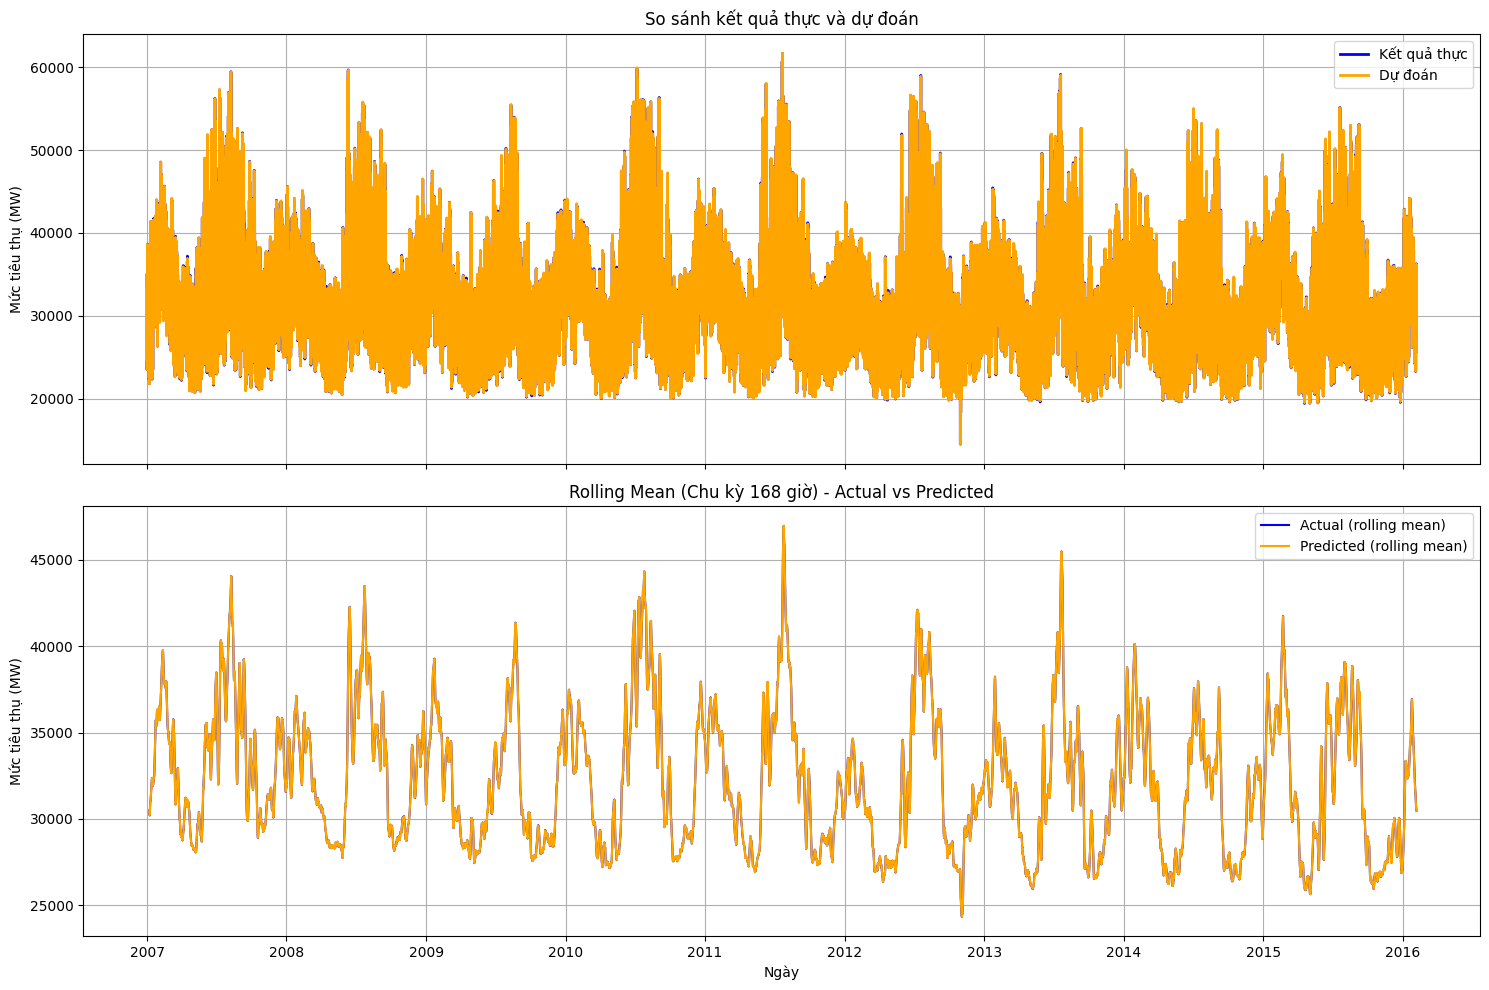

MAE : 73.73 (~0 nghĩa là tốt hơn)
MAPE: 0.23% (~0 nghĩa là tốt hơn)
MSE : 9178.51 (~0 nghĩa là tốt hơn)
Pearson's r 1.00 (~1 nghĩa là phản ánh được xu hướng)


In [23]:
train_repredict = pd.Series(xgb_model.predict(X_train), index=X_train.index)

plot_compare(y_train, train_repredict)
score_compare(y_train, train_repredict)

### Đánh giá trên tập test

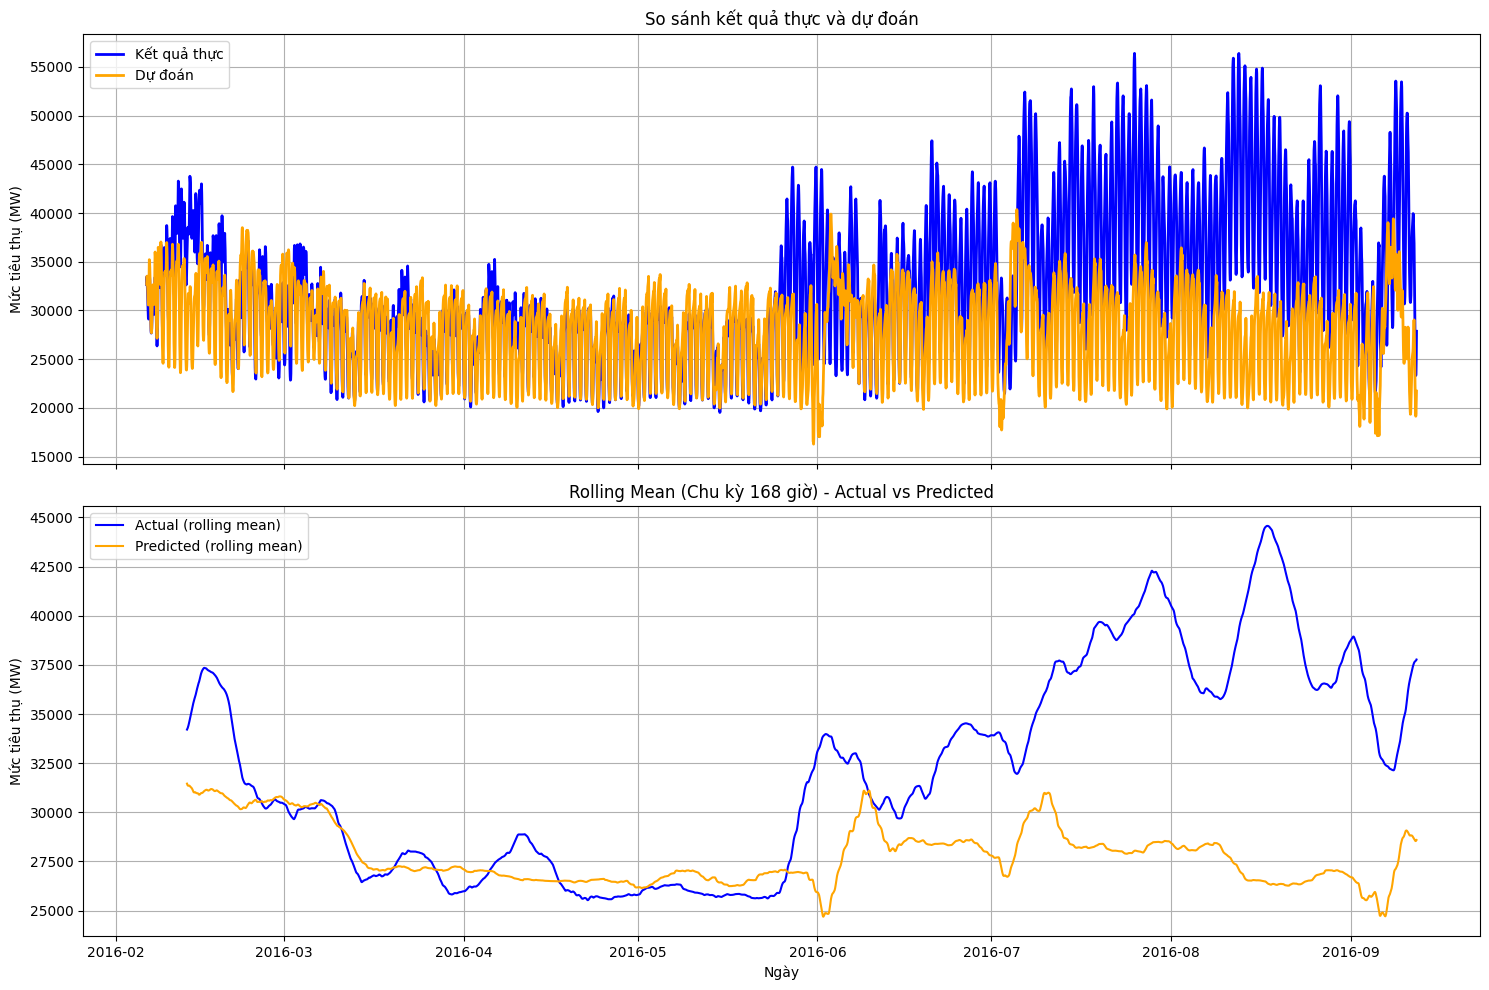

MAE : 5549.56 (~0 nghĩa là tốt hơn)
MAPE: 15.22% (~0 nghĩa là tốt hơn)
MSE : 61212190.09 (~0 nghĩa là tốt hơn)
Pearson's r 0.52 (~1 nghĩa là phản ánh được xu hướng)


In [24]:
test_predict = pd.Series(y_predict, index=y_predict.index) # đã dự đoán ở 6.1

zoom = (0, 0.6)       # Khu vực zoom in của biểu đồ (theo %)

draw_len = test_predict.size
start = int(draw_len * zoom[0])
end = int(draw_len * zoom[1])

# start = 0
# end = 168

plot_compare(y_test[start:end], test_predict[start:end], rolling_period=24*7)
score_compare(y_test[start:end], test_predict[start:end])

<h4>Nhận xét:</h4>
<p>Mô hình có một phần dự đoán được xu hướng thay đổi của dữ liệu (thông qua điểm Pearson's r). Kiểm tra các dự đoán trong tuần đầu tiên của tập test cho thấy khả năng phản ảnh chu kỳ ngày khá chính xác. Tuy nhiên, với các chu kỳ cao hơn (tuần, năm) đang gặp vấn đề, khi kết quả dự đoán và số liệu gốc phân nhánh sớm chỉ sau một vài ngày. Tổng thể lâu dài, dự đoán cũng ổn định hơn và rõ ràng không bắt được thay đổi theo chu kỳ năm.</p>

---
# 7. Hiệu chỉnh:
<p>Như với đồ thị kết quả thực hiện trên tập test, mặc dù đúng như dự đoán, khả năng dự đoán của mô hình giảm dần theo thời gian càng xa do đặc điểm tích lũy sai số của phương pháp Auto Regressive. Tuy nhiên, ta cũng đồng thời nhận thấy việc mô hình không phản ánh được một số trend nhất định liên quan tới các đặc trưng lâu dài. </p>

<h5>Điều này có thể do nhiều nguyên nhân.</h>
<ul>
    <li>Do phương pháp training: ta chỉ tập trung fit dữ liệu ngắn hạn, có thể điều này vô tình thúc đẩy model bỏ qua các đặc trưng dài hạn, tương ứng với các chu kỳ có tần số thấp hơn (chu kỳ mùa vụ, theo năm)</li>
    <li>Thiếu feature hiệu quả: Vì chu kỳ mùa vụ có tần số thấp nên ta không tạo được các đặc trưng lag, diff đủ nhiều, và các đặc trưng rolling statistic với khối lượng lớn dữ liệu cũng kém hiệu quả</li>
</ul>

<p>
    <h5>Giải pháp 1:</h5>
    <ul>
        <li>Sử dụng các đặc trưng phản ánh chu kỳ mùa vụ tốt hơn.<br> Cụ thể ở đây là sin(2*pi * day_of_year) với day_of_year là thứ tự của ngày đó trong 1 năm.</li>
        <li>Thực hiện tách tập training thành nhiều tập nhỏ, thực hiện recursive training.<br> Recursive training, về mặt ý tưởng, thực hiện dự đoán lần lượt các từng điểm mốc như ta đã thực hiện với tập test ban đầu, khi này các đặc trưng ngắn hạn tạo ra bởi các dự đoán đó trở lên thiếu tin cậy hơn, trong khi các đặc trưng dài hạn, vẫn là ground-truth tin cậy, có thể được mô hình sử dụng nhiều hơn.</li>
    </ul>

    => Kết quả: Không hiệu quả. Các đặc trưng chu kỳ dài hạn ảnh hưởng không đủ mạnh kể cả khi các đặc trưng ngắn hạn đã giảm tin cậy. Sau các vòng lặp, mô hình tăng bias thay vì chịu tập trung vào các đặc trưng mong muốn
</p>

<p>
    <h5>Giải pháp 2:</h5>
        Sử dụng mô hình bổ trợ chỉ học riêng các đặc trưng dài hạn. Với nền là mô hình bổ trợ đó, mô hình chính (mà ở đây là XGB) sẽ học các sai số cụ thể hơn để fit được kết quả.

    => Kết quả: 
</p>


## 7.1. Về mô hình bổ trợ

Mô hình bổ trợ được lựa chọn là Meta Prophet. Được phát triển bởi Meta nhằm dự đoán các xu hướng (trend) khớp với các nhu cầu bổ sung của mô hình ta đang thực hiên (theo năm, mùa,...). Đồng thời, mô hình này không yêu cầu việc tạo dựng đặc trưng, nên cũng dễ lồng ghép hơn.

Chi tiết quá trình xây dựng mô hình này đã được đề cập trong [Prophet.ipynb](./Prophet.ipynb)

In [25]:
def create_features_Datetime(df):

  df['Year'] = df.index.year
  df['Quarter'] = df.index.quarter
  df['Month'] = df.index.month
  df['Day'] = df.index.day
  df['Hour'] = df.index.hour

  df['Day_of_Year'] = df.index.dayofyear

  df['Weekday'] = df.index.weekday
  df['Is_Weekend'] = df['Weekday'].isin([5, 6]).astype(np.int8)

  df['Season'] = df['Month'].apply(lambda x: 
                                             1 if (x >= 3 and x <= 5) else  # Xuân
                                             2 if (x >= 6 and x <= 8) else  # Hạ
                                             3 if (x >= 9 and x <= 11) else  # Thu
                                             4) # Đông

  return df

def feature_engineering(df):
    df = df.copy()

    # Rolling statistics (shift bằng window để căn chỉnh ngày/tuần)
    for window in [24, 24*7]:
        df[f'rolling_mean_{window}h'] = df.iloc[:, 0].shift(1).rolling(window=window).mean()      # window=24 thì rolling[-24, -1]
        df[f'rolling_std_{window}h'] = df.iloc[:, 0].shift(1).rolling(window=window).std()
        df[f'rolling_min_{window}h'] = df.iloc[:, 0].shift(1).rolling(window=window).min()
        df[f'rolling_max_{window}h'] = df.iloc[:, 0].shift(1).rolling(window=window).max()

        df[f'rolling_mean_{window}h_lag_{window}h'] = df.iloc[:, 0].shift(window).rolling(window=window).mean()      # window=24 thì rolling[-48, -24]
        df[f'rolling_std_{window}h_lag_{window}h'] = df.iloc[:, 0].shift(window).rolling(window=window).std()
        df[f'rolling_min_{window}h_lag_{window}h'] = df.iloc[:, 0].shift(window).rolling(window=window).min()
        df[f'rolling_max_{window}h_lag_{window}h'] = df.iloc[:, 0].shift(window).rolling(window=window).max()


    # Tính lag_diff. 
    # Vd diff_1d_lag_2d là độ biến thiên của hôm kia so với hôm kìa 
    # base_1h là giá trị của giờ trước đó
    for diff, lag in [(1, 24), (24, 6), (24*7, 5), (24*365, 4)]:
        df[f'lag_{diff}h'] = df.iloc[:, 0].shift(diff)         # là lag_24h với delay 24h nữa, a.k.a lag_48h nhưng cũng không hẳn
        diff_value = df.iloc[:,0].diff(diff) / df[f'base_{diff}h']  # lẩy phần trăm, chuyển là diff theo %

        df[f'diff_{diff}h_lag_{diff}h'] = diff_value.shift(diff)    # tạo lag để tránh leakage
        for i in range(2, lag+1) :
            df[f'diff_{diff}h_lag_{i*diff}h'] = df[f'diff_{diff}h_lag_{(i-1)*diff}h'].shift(diff)
            

    # Drop rows with any NaN values
    # Lưu ý đoạn trên, nếu diff * lag quá lớn thì drop gần hết bảng
    df.dropna(inplace=True)

    return df

In [26]:
import tqdm as notebook_tqdm
from prophet import Prophet

c:\Users\Blade\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
train_prophet = train_data.iloc[:, 0].copy().reset_index()  # chỉ lấy cột cần dự đoán và index là đủ

train_prophet.rename(columns={
                            'index': 'ds', 
                            train_data.columns[0]: 'y'}, 
                    inplace=True)

prophet_model = Prophet(
    yearly_seasonality=True,
    seasonality_mode='additive'  # có thể thử 'additive', 'multiplicative'
)

prophet_model.fit(train_prophet)

23:32:13 - cmdstanpy - INFO - Chain [1] start processing
23:33:01 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
test_prophet_X = test_data.copy().reset_index()

test_prophet_X.rename(columns={
                            'index': 'ds'},
                    inplace=True)

prophet_predict = prophet_model.predict(test_prophet_X)

prophet_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21809 entries, 0 to 21808
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          21809 non-null  datetime64[ns]
 1   trend                       21809 non-null  float64       
 2   yhat_lower                  21809 non-null  float64       
 3   yhat_upper                  21809 non-null  float64       
 4   trend_lower                 21809 non-null  float64       
 5   trend_upper                 21809 non-null  float64       
 6   additive_terms              21809 non-null  float64       
 7   additive_terms_lower        21809 non-null  float64       
 8   additive_terms_upper        21809 non-null  float64       
 9   daily                       21809 non-null  float64       
 10  daily_lower                 21809 non-null  float64       
 11  daily_upper                 21809 non-null  float64   

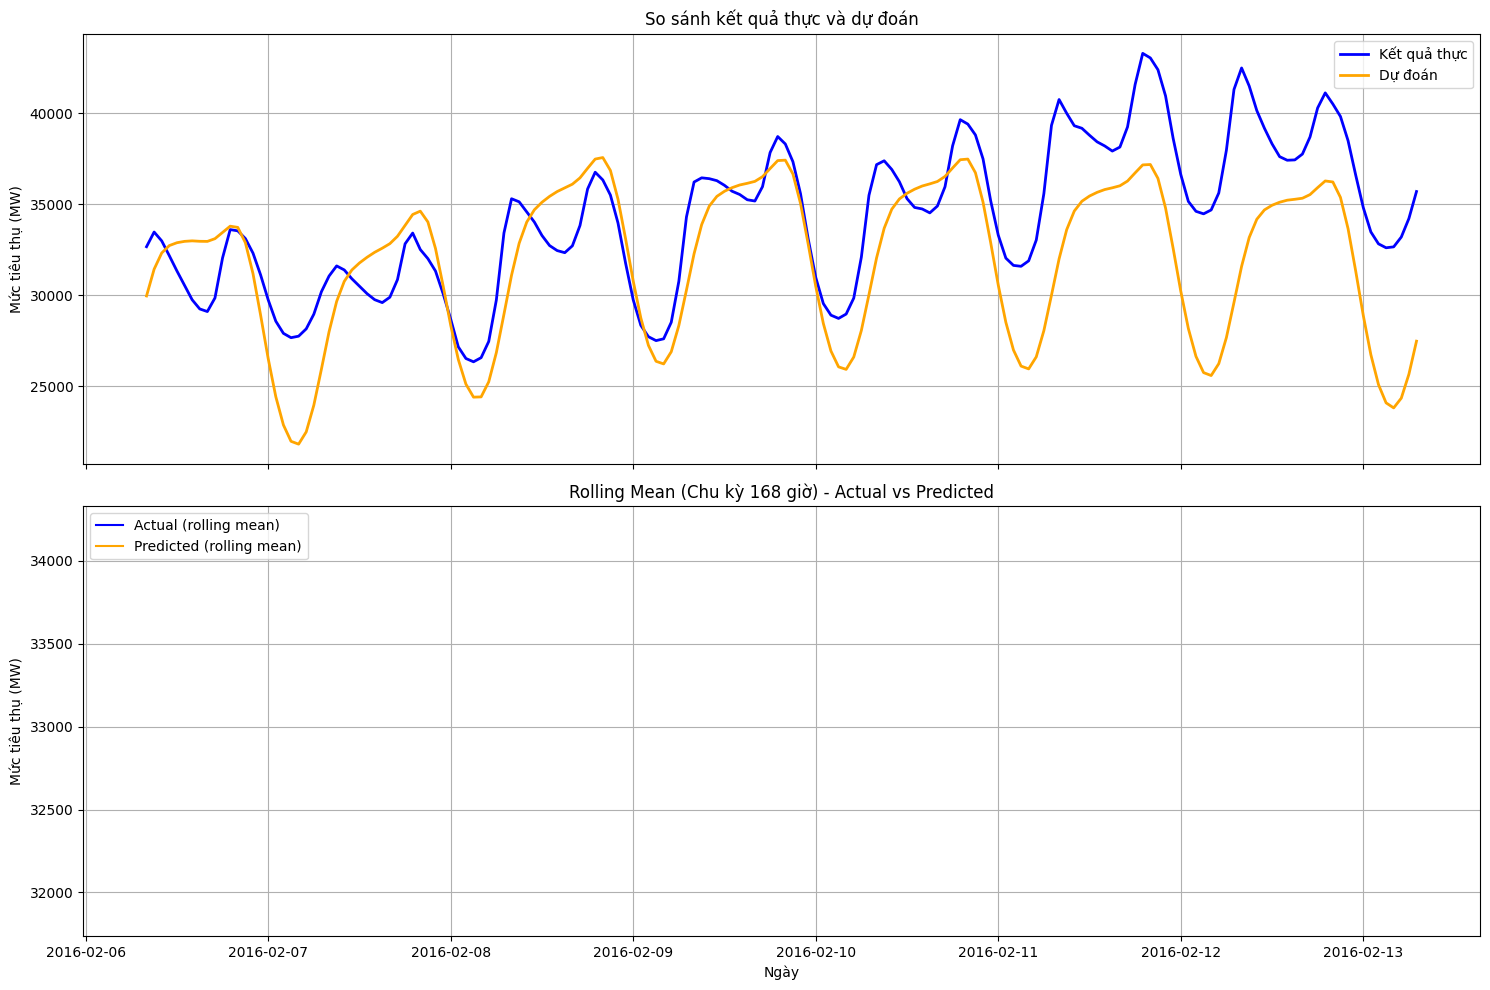

2016-02-06 08:00:00    32668.0
2016-02-06 09:00:00    33474.0
2016-02-06 10:00:00    32987.0
2016-02-06 11:00:00    32173.0
2016-02-06 12:00:00    31337.0
                        ...   
2016-02-13 03:00:00    32610.0
2016-02-13 04:00:00    32661.0
2016-02-13 05:00:00    33199.0
2016-02-13 06:00:00    34215.0
2016-02-13 07:00:00    35697.0
Freq: h, Name: PJME_MW, Length: 168, dtype: float64

In [ ]:
zoom = (0., 1)       # Khu vực zoom in của biểu đồ (theo %)

draw_len = test_predict.size
start = int(draw_len * zoom[0])
end = int(draw_len * zoom[1])

start = 0
end = 168

test_predict = prophet_predict.set_index('ds').loc[y_test.index, 'yhat'] # đã dự đoán ở 6.1
plot_compare(y_test[start:end], test_predict[start:end])

<p>
<h3>Kết luận:</h3>
 Mô hình prophet có thế mạnh trong xử lý dữ liệu mang tính chu kỳ/ mùa vụ, trong đó có chu kỳ theo năm mà XGBoost đang yếu.
</p>

## 7.2. Tích hợp mô hình

<h4>Phương pháp:</h4>
<p>Tên gọi: <strong>Stacking (Stacked Generalization)</strong></p>
<p>Quy trình cụ thể:</p>
<ol>
    <li>Sử dụng model Prophet nhận diện xu hướng cơ bản. Tập trung vào chu kỳ năm (yearly), hoặc rolling_mean.</li>
    <li>Model XGBoost sau đó sẽ học các nhiễu hoặc biến đổi với chu kỳ thấp hơn, thông qua sự chênh lệch giữa kết quả của prophet và ground_truth.</li>
    <li>Kết quả được đưa ra sẽ là tổng hợp dự đoán từ 2 mô hình.</li>
</ol>

<p>Về triển khai</p>
<ul>
    <li>Chọn lọc đặc trưng: Từ kết quả của mô hình XGB thuần, ta biết được một vài đặc trưng quan trọng nhất model cần sử dụng. Các đặc trưng không hiệu quả ta sẽ tinh giảm, lọc bớt.</li>
    <li>Triển khai Prophet: Xây dựng model prophet (đã thực hiện ở 7.1), model này sẽ học và đưa ra khá nhiều thông số, tuy nhiên, ta sẽ chỉ tập trung vào các tập giá trị trung bình (yhat, yearly, weekly, daily,..). Đưa chung các giá trị này cho XGB học.</li>
    <li>Triển khai XGBoost: Tùy vào khả năng thực hiện của mô hình, ta sẽ để XGB dự đoán các phần dư (residual) mà Prophet chưa thực hiện được, hoặc để XGB học cả kết quả của Prophet và đưa thẳng ra dự đoán cuối (final).</li>
</ul>


### Lấy dữ liệu

In [259]:
dataset = pd.read_csv('data/PJME_hourly.csv')

dataset['Datetime'] = pd.to_datetime(dataset['Datetime'])
dataset.set_index('Datetime', inplace=True)
dataset.sort_index(ascending=True, inplace=True)

fulfill_pipeline = Pipeline(steps=[
    ('Lấy trung bình các dòng bị lặp', FunctionTransformer(mean_duplicate_rows)),
    ('Nội suy các dòng thiếu', FunctionTransformer(interpolate_missing_rows))
]) 

dataset = fulfill_pipeline.fit_transform(dataset)

train_size = int(0.85 * len(dataset))

C:\Users\Blade\AppData\Local\Temp\ipykernel_14316\977346689.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_full = pd.concat([df, df_missing]).sort_index()        # Thêm các Datetime đang missing vào


In [260]:
train_data = dataset.iloc[:train_size].copy()

test_data = dataset.iloc[train_size:].copy()

target_col = train_data.columns[0]

# Cột cần dự đoán (PJME_MW)

### Huấn luyện Prophet

Thực hiện huấn luyện và dự đoán lên toàn bộ dữ liệu ta có được. Về cơ bản thì dự đoán từ prophet sẽ chỉ giữ vai trò đặc trưng phụ cho XGBoost. Còn về tính chính xác của mô hình thì đã có file xem xét riêng.

In [ ]:
train_prophet = train_data.iloc[:, 0].copy().reset_index()  # chỉ lấy cột cần dự đoán và index là đủ

train_prophet.rename(columns={
                            'index': 'ds', 
                            train_data.columns[0]: 'y'}, 
                    inplace=True)

prophet_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='additive'  # có thể thử 'additive', 'multiplicative'
)

prophet_model.fit(train_prophet)

01:41:58 - cmdstanpy - INFO - Chain [1] start processing


In [ ]:
all_prophet_X = dataset.copy().reset_index()

all_prophet_X.rename(columns={
                            'index': 'ds'},
                    inplace=True)

prophet_predict = prophet_model.predict(all_prophet_X)

prophet_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145392 entries, 0 to 145391
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   ds                          145392 non-null  datetime64[ns]
 1   trend                       145392 non-null  float64       
 2   yhat_lower                  145392 non-null  float64       
 3   yhat_upper                  145392 non-null  float64       
 4   trend_lower                 145392 non-null  float64       
 5   trend_upper                 145392 non-null  float64       
 6   additive_terms              145392 non-null  float64       
 7   additive_terms_lower        145392 non-null  float64       
 8   additive_terms_upper        145392 non-null  float64       
 9   daily                       145392 non-null  float64       
 10  daily_lower                 145392 non-null  float64       
 11  daily_upper                 145392 non-

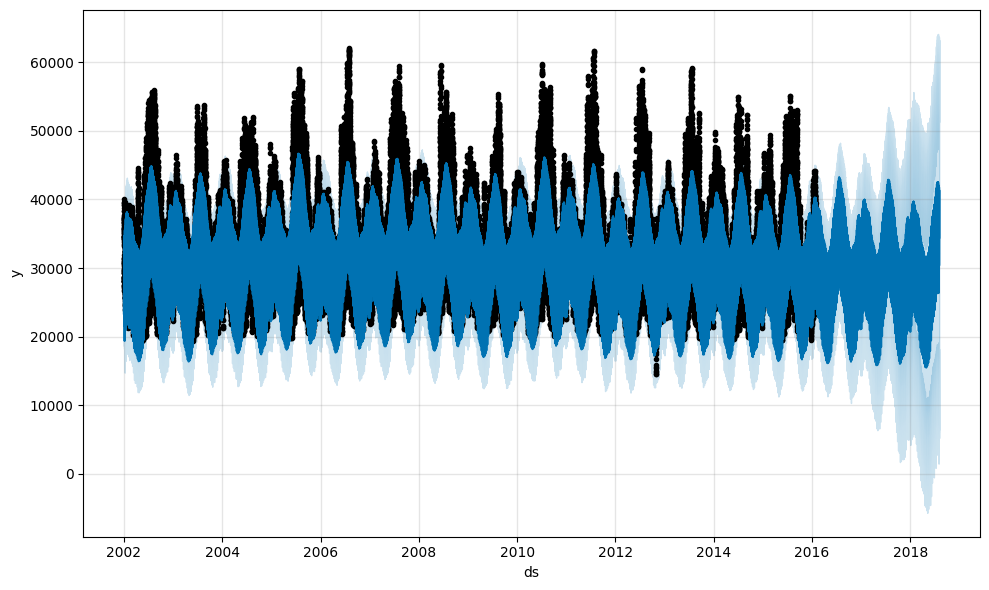

In [ ]:
fig = prophet_model.plot(prophet_predict)
plt.show()


Ta sẽ lấy một vài cột từ prophet_predict để làm extra_info cho hàm recursive_predict_extra

In [ ]:
selected_columns = ['ds', 'trend', 'yhat', 'yearly', 'weekly', 'daily', 'additive_terms']
extra_set = prophet_predict[selected_columns].set_index('ds')

### Thêm các cột extra (prophet dự đoán) vào bộ dữ liệu

In [ ]:
dataset_extra = dataset.join(extra_set, how='left')

dataset_extra

,PJME_MW,trend,yhat,yearly,weekly,daily,additive_terms
2002-01-01 01:00:00,30393.0,28301.713717,25670.029781,405.824292,1363.208744,-4400.716972,-2631.683936
2002-01-01 02:00:00,29265.0,28302.810719,24206.047840,408.963516,1377.941202,-5883.667596,-4096.762878
2002-01-01 03:00:00,28357.0,28303.907720,23362.901071,412.143150,1387.499929,-6740.649728,-4941.006649
2002-01-01 04:00:00,27899.0,28305.004722,23242.043933,415.363164,1392.378297,-6870.702250,-5062.960789
2002-01-01 05:00:00,28057.0,28306.101724,23932.795724,418.623521,1393.083605,-6185.013125,-4373.305999
...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,30297.199842,41358.089882,5637.198797,977.250939,4446.440304,11060.890040
2018-08-02 21:00:00,43256.0,30297.162766,40575.249694,5631.972894,965.443124,3680.670911,10278.086929
2018-08-02 22:00:00,41552.0,30297.125690,38943.048965,5626.745976,953.581490,2065.595808,8645.923275
2018-08-02 23:00:00,38500.0,30297.088614,36745.098189,5621.518161,941.465949,-114.974535,6448.009575


### **Phân nhánh** 
Như đã nói trước đó, ta có 2 hướng đi:
<ol>
    <li>Dùng các đặc prophet tạo ra, làm input cho XGBoost</li>
    <li>Dùng XGBoost để dự đoán phần dư (residual) mà prophet không làm được</li>
</ol>

- Nếu theo hướng đi số 1: <strong>bỏ qua đoạn code trong đây</strong>.<br> 

- Nếu theo hướng đi số 2: 

In [ ]:
target_col = 'residual'

dataset_extra['residual'] = dataset_extra.iloc[:, 0] - (dataset_extra['yearly'] + dataset_extra['weekly'] * 0.17)

train_data = dataset_extra.iloc[:train_size].copy()

test_data = dataset_extra.iloc[train_size:].copy()

dataset_extra['residual']

ds
2002-01-01 01:00:00    27664.143938
2002-01-01 02:00:00    27659.597199
2002-01-01 03:00:00    27655.889582
2002-01-01 04:00:00    27652.937248
2002-01-01 05:00:00    27650.653990
                           ...     
2018-08-02 20:00:00    24493.868385
2018-08-02 21:00:00    24501.064541
2018-08-02 22:00:00    24508.270860
2018-08-02 23:00:00    24515.521242
2018-08-03 00:00:00    24522.854949
Name: residual, Length: 145392, dtype: float64

<p>Ý tưởng của phương pháp stacking này là chia để trị. Trong khi mô hình Prophet có thế mạnh trong dự đoán chu kỳ dài hạn, ngược lại, các đặc trưng bộ nhớ ta sử dụng và phương pháp train mô hình XGBoost khiến nó tập trung toàn bộ vào dự đoán chu kỳ ngắn hạn. Việc kết hợp hai mô hình lại nhằm phân công việc dự đoán các chu kỳ đó cho 2 model.</p>

<p>Nói như vậy cũng có nghĩa, nếu residual (phần chưa được Prophet dự đoán), cũng phải có tính chu kỳ nhất định thì việc sử dụng thêm XGBoost dự đoán khoảng trống đó mới thực sự khả thi. Vì vậy, sau đây ta sẽ thử đánh giá tính dừng của residual.</p> 

<p>Phương pháp được sử dụng, một lần nữa, sẽ là biểu đồ ACF.</p>

(-0.6, 1.2)

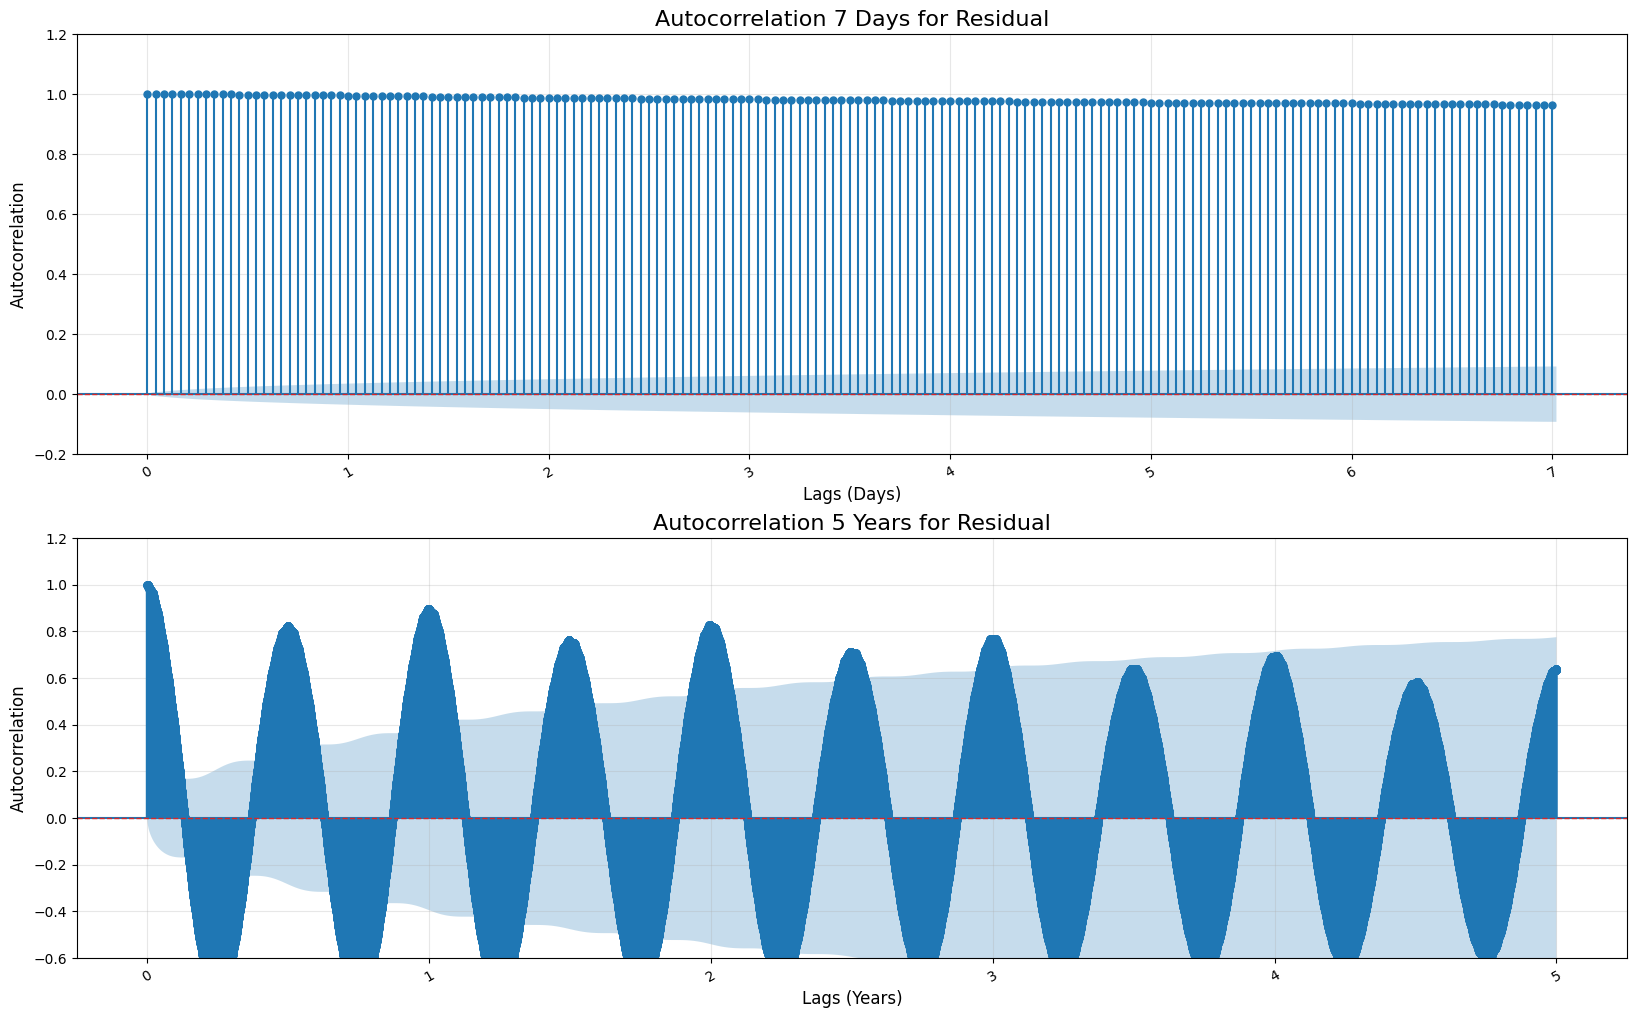

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

acf_color = '#1f77b4'   
zero_line_color = '#d62728'  

# Biểu đồ ACF 7 ngày
plot_acf(dataset_extra['residual'], lags=24*7, ax=ax[0], color=acf_color)
ax[0].set_title('Autocorrelation 7 Days for Residual', fontsize=16)
ax[0].set_xlabel('Lags (Days)', fontsize=12)
ax[0].set_ylabel('Autocorrelation', fontsize=12)
ax[0].axhline(0, color=zero_line_color, linestyle='--', linewidth=1)
ax[0].grid(alpha=0.3)

hours_featured = [i for i in range(0, 7*24+1, 24)]
ax[0].set_xticks(hours_featured)
days_featured = [f"{hour / 24:.0f}" for hour in hours_featured]
ax[0].set_xticklabels(days_featured, rotation=30)
ax[0].grid(alpha=0.3)


# Biểu đồ ACF 5 năm
plot_acf(dataset_extra['residual'], lags=24*365*5, ax=ax[1], color=acf_color)
ax[1].set_title('Autocorrelation 5 Years for Residual', fontsize=16)
ax[1].set_xlabel('Lags (Years)', fontsize=12)
ax[1].set_ylabel('Autocorrelation', fontsize=12)
ax[1].axhline(0, color=zero_line_color, linestyle='--', linewidth=1)

hours_featured = [i for i in range(0, 5*365*24+1, 365*24)]
ax[1].set_xticks(hours_featured)
days_featured = [f"{hour / (365*24):.0f}" for hour in hours_featured]
ax[1].set_xticklabels(days_featured, rotation=30)
ax[1].grid(alpha=0.3)

ax[0].set_ylim(-0.2, 1.2)
ax[1].set_ylim(-0.6, 1.2)

##### Nhận xét
Ta vẫn nhận thấy các chu kỳ theo năm và theo ngày. Điều này có nghĩa prophet không hoàn toàn lọc được các chu kỳ hiệu quả như ta nghĩ, đồng thời, residual vẫn khó có thể được cân đối chính xác bởi XGBoost.

### Chọn lọc đặc trưng và chuẩn bị Recursive Predicting


In [ ]:
def create_features_Datetime(df):
  # Bỏ: Season, Month, Quarter, Cos_h, Sin_h, Is_Weekend

  df['Year'] = df.index.year
  df['Day'] = df.index.day

  df['Hour'] = df.index.hour

  df['Day_of_Year'] = df.index.dayofyear
  df['Sin_doy'] = np.sin(2 * np.pi * df['Day_of_Year'] / 365)
  df['Cos_doy'] = np.cos(2 * np.pi * df['Day_of_Year'] / 365)

  df['Weekday'] = df.index.weekday

  return df

In [ ]:
def feature_engineering(df):
    df = df.copy()

    # Rolling statistics (shift bằng window để căn chỉnh ngày/tuần)
    for window in [24*7]:
        df[f'rolling_mean_{window}h'] = df[target_col].shift(1).rolling(window=window).mean()      # window=24 thì rolling[-24, -1]
        df[f'rolling_std_{window}h'] = df[target_col].shift(1).rolling(window=window).std()
        df[f'rolling_min_{window}h'] = df[target_col].shift(1).rolling(window=window).min()

        df[f'rolling_mean_{window}h_lag_{window}h'] = df[target_col].shift(window).rolling(window=window).mean()      # window=24 thì rolling[-48, -24]
        df[f'rolling_std_{window}h_lag_{window}h'] = df[target_col].shift(window).rolling(window=window).std()
        df[f'rolling_min_{window}h_lag_{window}h'] = df[target_col].shift(window).rolling(window=window).min()


    # Tính lag_diff. 
    # Vd diff_1d_lag_2d là độ biến thiên của hôm kia so với hôm kìa 
    # base_1h là giá trị của giờ trước đó
    for diff, lag in [(24, 21), (24*7, 8), (24*365, 4)]:
        df[f'lag_{diff}h'] = df[target_col].shift(diff)         # là lag_24h với delay 24h nữa, a.k.a lag_48h nhưng cũng không hẳn
        diff_value = df[target_col].diff(diff) / df[f'lag_{diff}h']  # lẩy phần trăm, chuyển là diff theo %

        df[f'diff_{diff}h_lag_{diff}h'] = diff_value.shift(diff)    # tạo lag để tránh leakage
        for i in range(2, lag+1) :
            df[f'diff_{diff}h_lag_{i*diff}h'] = df[f'diff_{diff}h_lag_{(i-1)*diff}h'].shift(diff)
            

    # Drop rows with any NaN values
    # Lưu ý đoạn trên, nếu diff * lag quá lớn thì drop gần hết bảng
    df.dropna(inplace=True)

    return df

In [ ]:
# Tạo đặc trưng cho huấn luyện
feature_engineering_pipeline = Pipeline(steps=[
    ('Tạo features từ index Datetime', FunctionTransformer(create_features_Datetime)),
    ('Tạo features từ cột MW (gốc)', FunctionTransformer(feature_engineering))
])

train_data = feature_engineering_pipeline.fit_transform(train_data)

In [ ]:
# đánh dấu ra đây để biết sẽ tồn tịa một list như thế để các hàm kiến tạo tuân thủ theo thôi
feature_columns = []

In [ ]:
# Xử lý cho testing set
def create_next_row_features (context) :
    # Bỏ rolling_max
    """
    Trả về một dict chứa thông tin các features có thể cần cho index Datetime tiếp theo của context.
    Điều kiện context phải sort rồi. (lúc chia đã sort).

    Sửa code thì phải theo cái create_feature trên pipeline tạo đặc trưng nha, khác tên cột, lệch đặc trưng sẽ báo lỗi.
    """
    next_row = {}
    for window in [24*7] :
        next_row[f'rolling_mean_{window}h'] = context[target_col].iloc[-window:].mean()
        next_row[f'rolling_std_{window}h'] = context[target_col].iloc[-window:].std()
        next_row[f'rolling_min_{window}h'] = context[target_col].iloc[-window:].min()

        next_row[f'rolling_mean_{window}h_lag_{window}h'] = context[target_col].iloc[-2*window+1:-window+1].mean()
        next_row[f'rolling_std_{window}h_lag_{window}h'] = context[target_col].iloc[-2*window+1:-window+1].std()
        next_row[f'rolling_min_{window}h_lag_{window}h'] = context[target_col].iloc[-2*window+1:-window+1].min()

    # Tính lag_diff. 
    # Vd diff_1d_lag_2d là độ biến thiên của hôm kia so với hôm kìa 
    # base_1h là giá trị của giờ trước đó
    for diff, lag in [(24, 21), (24*7, 8), (24*365, 4)]:
        next_row[f'lag_{diff}h'] = context[target_col].iloc[-diff]
        next_row[f'diff_{diff}h_lag_{diff}h'] = (context[target_col].iloc[-diff] - context[target_col].iloc[-diff*2]) / next_row[f'lag_{diff}h']
        for i in range(2, lag+1) :
            next_row[f'diff_{diff}h_lag_{i*diff}h'] = context.iloc[-diff,][f'diff_{diff}h_lag_{(i-1)*diff}h'] 

    return next_row

def create_datetime_features(time:pd.DatetimeIndex) :
    time_features = {}
    time_features['Year'] = time.year
    time_features['Day'] = time.day

    time_features['Hour'] = time.hour

    time_features['Day_of_Year'] = time.dayofyear
    time_features['Sin_doy'] = np.sin(2 * np.pi * time.dayofyear / 365)
    time_features['Cos_doy'] = np.cos(2 * np.pi * time.dayofyear / 365)

    time_features['Weekday'] = time.weekday()
    
    return time_features

def recursive_predict_extra(model, context, end_predict, extra_info:pd.DataFrame, result_only=True) :
    one_hour = pd.Timedelta('1h')
    last_context_index = context.index[-1]
    current_time = last_context_index + one_hour 

    zero = context.columns[0]
    MW = target_col
    while current_time <= end_predict:
        extra = extra_info.loc[current_time].to_dict()
        if zero == MW :
            new_row = {MW : np.nan} | \
                        create_datetime_features(current_time) | \
                            create_next_row_features(context) | \
                                extra
            new_row = pd.DataFrame(new_row, index=[current_time])[[MW] + list(feature_columns)]
        else :
            new_row = {zero : np.nan} | \
                        {MW : np.nan} | \
                            create_datetime_features(current_time) | \
                                create_next_row_features(context) | \
                                    extra
            new_row = pd.DataFrame(new_row, index=[current_time])[[zero, MW] + list(feature_columns)]
        

        # Dự đoán dòng mới
        new_row.loc[current_time, MW] = model.predict(new_row[feature_columns])[0]

        frame = min([8760*2+10, len(context)])
        context = pd.concat([context.tail(frame), new_row])           ## Để giảm tải thời gian copy
        current_time += one_hour

    last_context_loc = context.index.get_loc(last_context_index)
    if result_only :
        return context[target_col].iloc[last_context_loc + 1:].copy()
    
    return context.iloc[last_context_loc + 1:, ].copy()

### Huấn luyện XGBoost

In [ ]:
# Reset lại tên các cột feature
feature_columns = [col for col in train_data.columns[1:] if col not in [target_col, 'yhat', 'yhat_upper', 'yhat_lower', 'additive_terms', 'additive_terms_upper', 'additive_terms_lower']]
print(feature_columns)
train_X = train_data[feature_columns]
train_y = train_data[target_col]

test_y = test_data[target_col]

['trend_lower', 'trend_upper', 'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower', 'multiplicative_terms_upper', 'Year', 'Day', 'Hour', 'Day_of_Year', 'Sin_doy', 'Cos_doy', 'Weekday', 'rolling_mean_24h', 'rolling_std_24h', 'rolling_min_24h', 'rolling_mean_24h_lag_24h', 'rolling_std_24h_lag_24h', 'rolling_min_24h_lag_24h', 'rolling_mean_168h', 'rolling_std_168h', 'rolling_min_168h', 'rolling_mean_168h_lag_168h', 'rolling_std_168h_lag_168h', 'rolling_min_168h_lag_168h', 'lag_1h', 'diff_1h_lag_1h', 'diff_1h_lag_2h', 'diff_1h_lag_3h', 'diff_1h_lag_4h', 'diff_1h_lag_5h', 'diff_1h_lag_6h', 'diff_1h_lag_7h', 'diff_1h_lag_8h', 'diff_1h_lag_9h', 'diff_1h_lag_10h', 'diff_1h_lag_11h', 'diff_1h_lag_12h', 'diff_1h_lag_13h', 'diff_1h_lag_14h', 'diff_1h_lag_15h', 'diff_1h_lag_16h', 'diff_1h_lag_17h', 'diff_1h_lag_18h', 'diff_1h_lag_19h', 'diff_1h_lag_20h', 'diff_1h_lag_21h', 'd

In [ ]:
# Khởi tạo mô hình với các siêu tham số đã tìm được
xgb_model = xgb.XGBRegressor(
    n_estimators=1500,
    learning_rate=0.05,
    max_depth=7,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42
)

# Huấn luyện mô hình trên tập huấn luyện
xgb_model.fit(train_X, train_y)

c:\Users\Blade\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:40:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:52: Empty dataset at worker: 0
  bst.update(dtrain, iteration=i, fobj=obj)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1500,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
booster = xgb_model.get_booster()
importance = booster.get_score(importance_type='weight')  # hoặc 'gain', 'cover'

importance = pd.Series(importance).sort_values(ascending=False)

for feature, score in importance.items():
    print(f"{feature}: {score}")

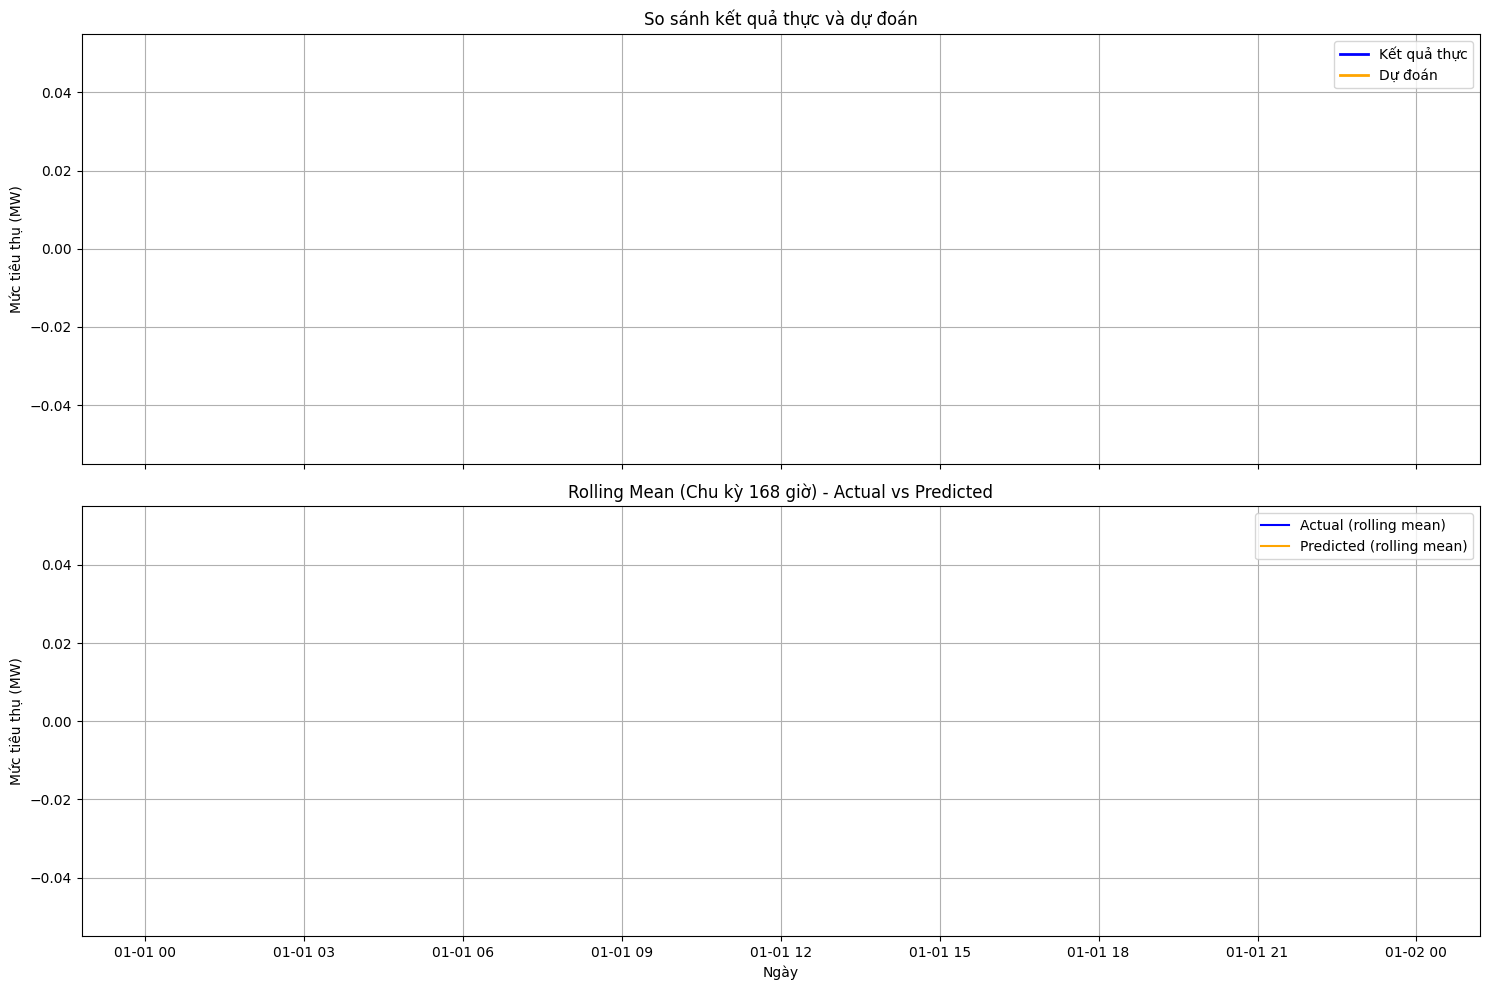

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [ ]:
train_repredict = pd.DataFrame(data=xgb_model.predict(train_X), index=train_X.index, columns=['result'])['result']

zoom = (0, 1)       # Khu vực zoom in của biểu đồ (theo %)

draw_len = test_predict.size
start = int(draw_len * zoom[0])
end = int(draw_len * zoom[1])

plot_compare(train_y[start:end], train_repredict[start:end], rolling_period=24*7)
score_compare(train_y[start:end], train_repredict[start:end])

In [ ]:
y_predict = recursive_predict_extra(model = xgb_model,
                                    context = train_data,
                                    end_predict = test_y.index[24*7*5], # hoặc đoán toàn bộ: y_test.index[-1],
                                    extra_info = test_data)     # extra_info lấy từ prophet
y_predict


KeyError: "['rolling_mean_24h', 'rolling_std_24h', 'rolling_min_24h', 'rolling_mean_24h_lag_24h', 'rolling_std_24h_lag_24h', 'rolling_min_24h_lag_24h', 'lag_1h', 'diff_1h_lag_1h', 'diff_1h_lag_2h', 'diff_1h_lag_3h', 'diff_1h_lag_4h', 'diff_1h_lag_5h', 'diff_1h_lag_6h', 'diff_1h_lag_7h', 'diff_1h_lag_8h', 'diff_1h_lag_9h', 'diff_1h_lag_10h', 'diff_1h_lag_11h', 'diff_1h_lag_12h', 'diff_1h_lag_13h', 'diff_1h_lag_14h', 'diff_1h_lag_15h', 'diff_1h_lag_16h', 'diff_1h_lag_17h', 'diff_1h_lag_18h', 'diff_1h_lag_19h', 'diff_1h_lag_20h', 'diff_1h_lag_21h', 'diff_1h_lag_22h', 'diff_1h_lag_23h', 'diff_1h_lag_24h'] not in index"

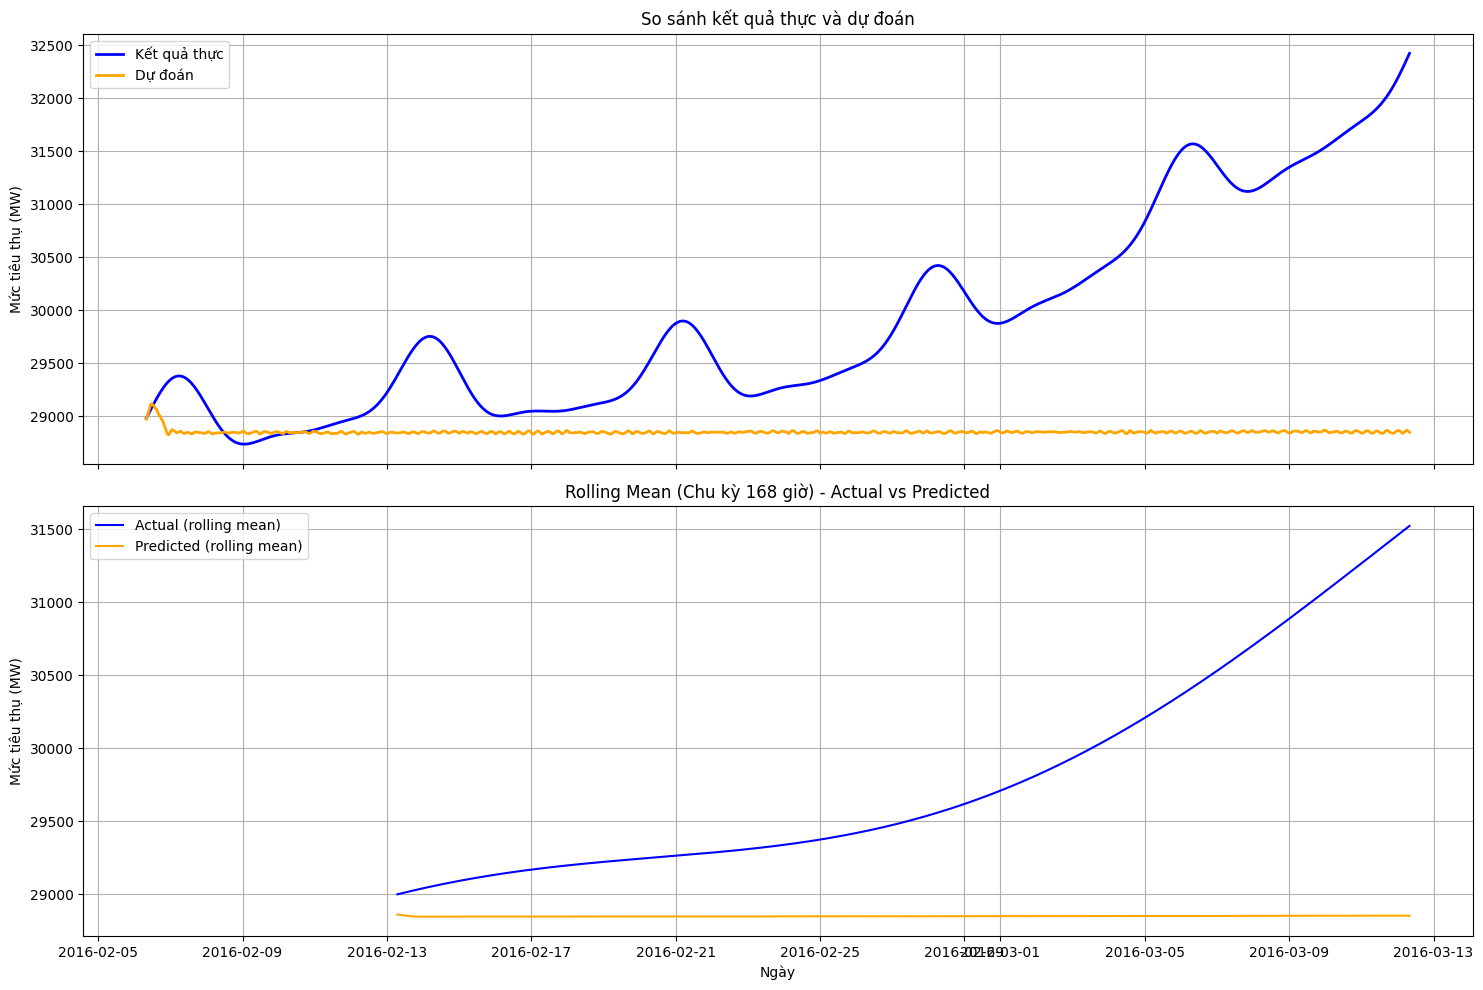

MAE : 1059.47 (~0 nghĩa là tốt hơn)
MAPE: 3.45% (~0 nghĩa là tốt hơn)
MSE : 2007709.66 (~0 nghĩa là tốt hơn)
Pearson's r -0.00 (~1 nghĩa là phản ánh được xu hướng)


In [ ]:
test_predict = pd.Series(y_predict, index=y_predict.index)
# Nếu đoán bằng residual thì sẽ phải cộng residual vào cột yhat. Còn không thì bỏ phần + đi

zoom = (0, 1)       # Khu vực zoom in của biểu đồ (theo %)

draw_len = test_predict.size
start = int(draw_len * zoom[0])
end = int(draw_len * zoom[1])

# start = 0
# end = 168 * 4

plot_compare(test_data[target_col].iloc[start:end], test_predict[start:end], rolling_period=24*7)
score_compare(test_data[target_col].iloc[start:end], test_predict[start:end])

---
# 7. Thử nghiệm mô hình khác
